Here's a rough demo of importing a specific subset of data from our data source (sqlite database in this case), and plotting some graphs from it. 
I want to see roughly when a player peaks in terms of point production, and how that relates to their draft position 

In [27]:
# import all external libraries we'll need
import matplotlib.pyplot as plt
import pandas as pd
#import numpy as np # don't actually need this one
import sqlite3
import seaborn as sns

In [28]:
# SQL details
# the name of our sqlite database that has all the daily and seasonal info
db_name = "NHLseasonML.db"

# query to parse data together from a couple tables. The parsing could be done inside Python but this was a
#  chance to practise up on some SQL at the same time.
sql_query = "select distinct s.playerID, s.playerName as 'Name', s.playerPositionCode as 'Pos', " \
         "b.playerDraftYear as 'Draft Year', b.playerDraftRoundNo as 'Round', " \
         "b.playerDraftOverallPickNo as 'Pick Overall', s.seasonId / 10000 as 'Season', " \
         "cast((julianday(cast(s.seasonId / 10000 as int) || '-09-15') - julianday(b.playerBirthDate)) / 365 as int) as PlayerAge" \
         ", s.gamesPlayed, s.Goals, s.Points,round((s.pointsPerGame * 3600 / s.timeOnIcePerGame),3) as 'Pointsper60'" \
         ", round(s.shootingPctg,3) as 'Shot %', round(s.pointsPerGame,3) as 'PPG'" \
         ", cast(s.timeOnIcePerGame as int) as 'Avg TOI (s)' from s_skater_summary s, s_bio_info b  " \
         "where s.playerID = b.playerId and s.gamesPlayed >= 10"

 Some quick notes about this SQL query. It's pulling from two tables: One with a summary of each player's productivity per season, and another with biographical info about the player (Date of birth, nationality, teams played for, draft details, etc). We only care about a handful of information, and certain things must be caluclated based on the information provided.
 For CBA purposes, the NHL considers the cutoff for any given season to be Sept 15, so we'll declare their age for a season to be how old they were on that date.
 There's a filter applied to reject a player's seasonal data if they played less than 10 games. That's likely too small of a sample to be worth including. 

In [29]:
# connect to our sqlite database (created previously using the stats_extract.py script). Assume it's is in the current dir
conn = sqlite3.connect(db_name)

# grab the data from SQL and put it in a data frame for easy manipulation
career_arc = pd.read_sql_query(sql_query, conn)

# we're done with the database now, so close off the connection
conn.close()

Let's take a look at the dataframe we've imported. Top 20 rows is a decent enough sample.

In [30]:
career_arc.head(n=20)

,playerId,Name,Pos,Draft Year,Round,Pick Overall,Season,PlayerAge,gamesPlayed,goals,points,Pointsper60,Shot %,PPG,Avg TOI (s)
0,8478414,Timo Meier,R,2015,1,9,2016,19,34,3,6,0.849,0.035,0.176,748
1,8475765,Vladimir Tarasenko,R,2010,1,16,2016,24,82,39,75,2.971,0.136,0.915,1108
2,8466148,Marian Hossa,R,1997,1,12,2016,37,73,26,45,2.194,0.156,0.616,1011
3,8475314,Anders Lee,L,2009,6,152,2016,26,81,34,52,2.471,0.178,0.642,935
4,8477964,Ivan Barbashev,C,2014,2,33,2016,20,30,5,12,2.035,0.250,0.400,707
5,8474062,Riley Nash,C,2007,1,21,2016,27,81,7,17,0.912,0.056,0.210,828
6,8477018,Ben Hutton,D,2012,5,147,2016,23,71,5,19,0.783,0.038,0.268,1229
7,8477488,Brett Pesce,D,2013,3,66,2016,21,82,2,20,0.690,0.018,0.244,1272
8,8474034,Patrick Maroon,L,2007,6,161,2016,28,81,27,42,1.859,0.152,0.518,1004
9,8476808,Brian Flynn,C,,,,2016,28,51,6,10,0.975,0.128,0.196,723


Note that there are some blank values where the draft values would normally go. These are for undrafted players, and will become a problem. In the SQL tables, these columns are Int datatypes with null values, however when read into a pandas dataframe the nulls aren't handled very well.

Checking the data types of all columns below, we see they're 'objects' as opposed to int64 like before. Must fix this.

In [31]:
career_arc.dtypes

playerId          int64
Name             object
Pos              object
Draft Year       object
Round            object
Pick Overall     object
Season            int64
PlayerAge         int64
gamesPlayed       int64
goals             int64
points            int64
Pointsper60     float64
Shot %          float64
PPG             float64
Avg TOI (s)       int64
dtype: object

These columns can be converted quite easily, which will allow us to filter them in the future.
Convert them, then re-examine the datatypes

In [32]:
career_arc["Pick Overall"] = pd.to_numeric(career_arc["Pick Overall"])
career_arc["Draft Year"] = pd.to_numeric(career_arc["Draft Year"])
career_arc["Round"] = pd.to_numeric(career_arc["Round"])
career_arc.dtypes

playerId          int64
Name             object
Pos              object
Draft Year      float64
Round           float64
Pick Overall    float64
Season            int64
PlayerAge         int64
gamesPlayed       int64
goals             int64
points            int64
Pointsper60     float64
Shot %          float64
PPG             float64
Avg TOI (s)       int64
dtype: object

Hooray, they're now floats. Pandas won't convert them to ints but who cares anyway. The data still remains beautiful, with some minor visual differences.

In [33]:
career_arc.head(n=20)

,playerId,Name,Pos,Draft Year,Round,Pick Overall,Season,PlayerAge,gamesPlayed,goals,points,Pointsper60,Shot %,PPG,Avg TOI (s)
0,8478414,Timo Meier,R,2015.0,1.0,9.0,2016,19,34,3,6,0.849,0.035,0.176,748
1,8475765,Vladimir Tarasenko,R,2010.0,1.0,16.0,2016,24,82,39,75,2.971,0.136,0.915,1108
2,8466148,Marian Hossa,R,1997.0,1.0,12.0,2016,37,73,26,45,2.194,0.156,0.616,1011
3,8475314,Anders Lee,L,2009.0,6.0,152.0,2016,26,81,34,52,2.471,0.178,0.642,935
4,8477964,Ivan Barbashev,C,2014.0,2.0,33.0,2016,20,30,5,12,2.035,0.250,0.400,707
5,8474062,Riley Nash,C,2007.0,1.0,21.0,2016,27,81,7,17,0.912,0.056,0.210,828
6,8477018,Ben Hutton,D,2012.0,5.0,147.0,2016,23,71,5,19,0.783,0.038,0.268,1229
7,8477488,Brett Pesce,D,2013.0,3.0,66.0,2016,21,82,2,20,0.690,0.018,0.244,1272
8,8474034,Patrick Maroon,L,2007.0,6.0,161.0,2016,28,81,27,42,1.859,0.152,0.518,1004
9,8476808,Brian Flynn,C,NaN,NaN,NaN,2016,28,51,6,10,0.975,0.128,0.196,723


For a quick example of what we can do with the data, lets grab a handful of player's info

In [34]:
sid = career_arc[career_arc["Name"] == "Sidney Crosby"].sort_values(by=["Season"])
ovie = career_arc[career_arc["Name"] == "Alex Ovechkin"].sort_values(by=["Season"])
stamkos = career_arc[career_arc["Name"] == "Steven Stamkos"].sort_values(by=["Season"])
dsedin = career_arc[career_arc["Name"] == "Daniel Sedin"].sort_values(by=["Season"])
smytty = career_arc[career_arc["Name"] == "Ryan Smyth"].sort_values(by=["Season"])

Now let's plot this info using Matplotlib. I'm terrible with this library but managed to scrape something together. We'll plot several lines on the same figure here and include some other details. 

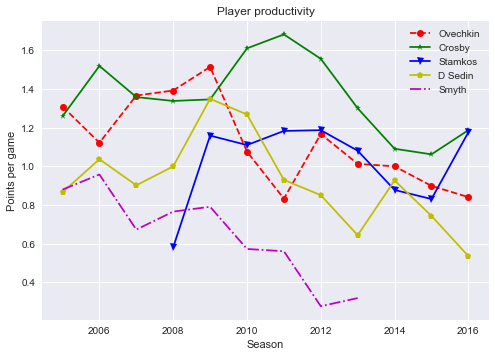

In [35]:
plt.plot(ovie["Season"], ovie["PPG"], marker='o', linestyle='--', color='r',label='Ovechkin')
plt.plot(sid["Season"], sid["PPG"], marker='*', linestyle='-', color='g', label='Crosby')
plt.plot(stamkos["Season"], stamkos["PPG"], marker='v', linestyle='-', color='b', label='Stamkos')
plt.plot(dsedin["Season"], dsedin["PPG"], marker='p', linestyle='-', color='y', label='D Sedin')
plt.plot(smytty["Season"], smytty["PPG"], marker='x', linestyle='-.', color='m', label='Smyth')

plt.xlabel('Season')
plt.ylabel('Points per game')
plt.title('Player productivity')
plt.legend(loc='upper right')
plt.show()

Not bad, clearly players were at different stages of their careers. Stamkos didn't play until 2008 and Smytty retired after the 2013/14 season. Let's re-examine the data comparing players when they were the same ages.

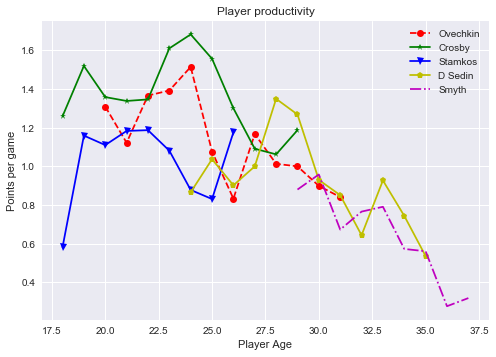

In [36]:
plt.plot(ovie["PlayerAge"], ovie["PPG"], marker='o', linestyle='--', color='r',label='Ovechkin')
plt.plot(sid["PlayerAge"], sid["PPG"], marker='*', linestyle='-', color='g', label='Crosby')
plt.plot(stamkos["PlayerAge"], stamkos["PPG"], marker='v', linestyle='-', color='b', label='Stamkos')
plt.plot(dsedin["PlayerAge"], dsedin["PPG"], marker='p', linestyle='-', color='y', label='D Sedin')
plt.plot(smytty["PlayerAge"], smytty["PPG"], marker='x', linestyle='-.', color='m', label='Smyth')

plt.xlabel('Player Age')
plt.ylabel('Points per game')
plt.title('Player productivity')
plt.legend(loc='upper right')
plt.show()

This is pretty neat. There's a wide range of player ages here so not entirely overlapping. Since the data set is all post-2004 lockout we're mising some of Jagr's younger years. That data could easily be added to the SQL database but I figured that the game changed so drastically that it's probably easier to start clean with 2005/06 data.
One other thing to consider is that points per game may be tied somewhat to ice time. There were a lot of complaints about Stamkos being limited by his coach when he was a rookie, if we plot Age vs Points per 60, it would be a good test of player efficiency.

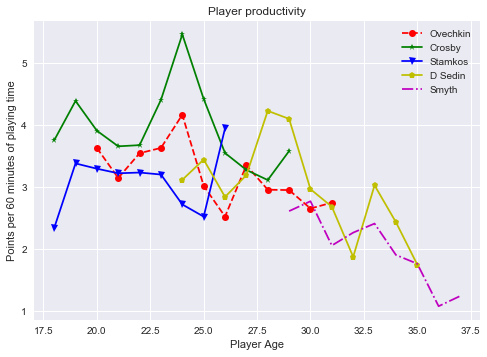

In [37]:
plt.plot(ovie["PlayerAge"], ovie["Pointsper60"], marker='o', linestyle='--', color='r',label='Ovechkin')
plt.plot(sid["PlayerAge"], sid["Pointsper60"], marker='*', linestyle='-', color='g', label='Crosby')
plt.plot(stamkos["PlayerAge"], stamkos["Pointsper60"], marker='v', linestyle='-', color='b', label='Stamkos')
plt.plot(dsedin["PlayerAge"], dsedin["Pointsper60"], marker='p', linestyle='-', color='y', label='D Sedin')
plt.plot(smytty["PlayerAge"], smytty["Pointsper60"], marker='x', linestyle='-.', color='m', label='Smyth')

plt.xlabel('Player Age')
plt.ylabel('Points per 60 minutes of playing time')
plt.title('Player productivity')
plt.legend(loc='upper right')
plt.show()

Crosby was such a killer in 2005/06. Also neat to see that Jagr has been so consistently productive in his old age.
Now, let's add another handful of players (top 6 forwards for consistency) to increase the sample size, and show this is a scatter plot instead.

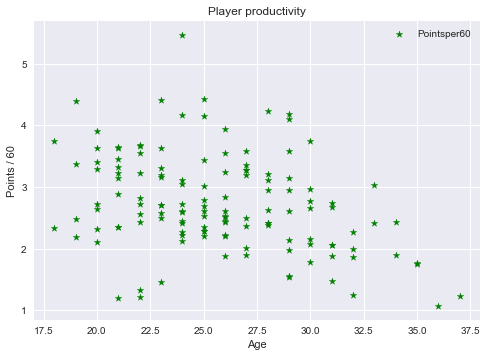

In [38]:
# create a bunch of mine dataframes, filtering the original one by player name, and sorting by season.
malkin = career_arc[career_arc["Name"] == "Evgeni Malkin"].sort_values(by=["Season"])
glenx = career_arc[career_arc["Name"] == "Curtis Glencross"].sort_values(by=["Season"])
kesler = career_arc[career_arc["Name"] == "Ryan Kesler"].sort_values(by=["Season"])
tavares = career_arc[career_arc["Name"] == "John Tavares"].sort_values(by=["Season"])
lupul = career_arc[career_arc["Name"] == "Joffrey Lupul"].sort_values(by=["Season"])
eberle = career_arc[career_arc["Name"] == "Jordan Eberle"].sort_values(by=["Season"])
kopi = career_arc[career_arc["Name"] == "Anze Kopitar"].sort_values(by=["Season"])
bryan = career_arc[career_arc["Name"] == "Bobby Ryan"].sort_values(by=["Season"])

# put these little dataframes back together in one. Filtering the main dataframe would be more efficient, we'll do that later.
both = pd.concat([malkin, glenx, kesler,tavares,lupul,eberle, ovie, sid, stamkos, dsedin, smytty,kopi,bryan])

plt.scatter(both["PlayerAge"], both["Pointsper60"], marker='*', linestyle='-', color='g')
plt.xlabel('Age')
plt.ylabel('Points / 60')
plt.title('Player productivity')
plt.legend(loc='upper right')
plt.show()

k, that's something. We should add a regression line to hopefully see a trend.

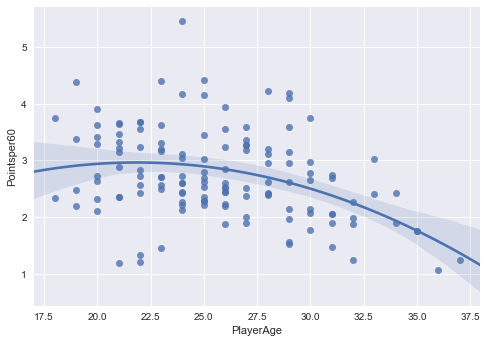

In [39]:
sns.regplot(both["PlayerAge"], both["Pointsper60"], data=both, order=2 )
plt.show()

Now that's useful. This subset of players looks to have an overall peak in performance around 22, then trailing off. This sample size is pretty skewed to guys drafted around 2005ish. Larger datasets will provide more clarity. For fun, let's throw everything in and see how it looks.

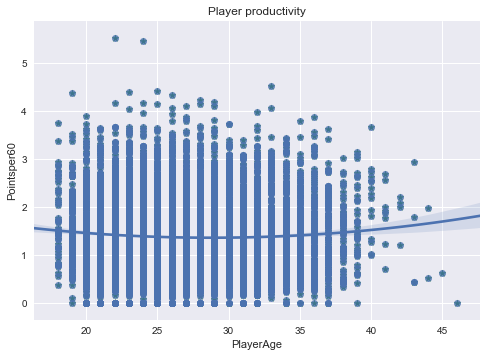

In [40]:
plt.scatter(career_arc["PlayerAge"], career_arc["Pointsper60"], marker='*', linestyle='-', color='g')
plt.xlabel('Age')
plt.ylabel('Points / 60')
plt.title('Player productivity')
sns.regplot(career_arc["PlayerAge"], career_arc["Pointsper60"], data=career_arc, order=2 )
plt.show()

Enough tinkering. Let's break it down by position (D vs F) and draft ranking. Also drop the seasons for people 40 and over, Chelios and Jagr are tainting results at the far end.

In [41]:
career_arc = career_arc[(career_arc["PlayerAge"] < 40)]
f_arc_top5 = career_arc[(career_arc["Pos"] != 'D') & (career_arc["Pick Overall"] <= 5)]
f_arc_other_first_round = career_arc[(career_arc["Pos"] != 'D') & (career_arc["Pick Overall"] > 5) & (career_arc["Round"] == 1)]
f_arc_2nd_4th_round = career_arc[(career_arc["Pos"] != 'D') & (career_arc["Round"] >= 2) & (career_arc["Round"] <= 4)]
f_arc_5th_and_beyond = career_arc[(career_arc["Pos"] != 'D') & (career_arc["Round"] >= 5) | (career_arc["Round"].isnull())]
d_arc_top5 = career_arc[(career_arc["Pos"] == 'D') & (career_arc["Pick Overall"] <= 5)]
d_arc_other_first_round = career_arc[(career_arc["Pos"] == 'D') & (career_arc["Pick Overall"] > 5) & (career_arc["Round"] == 1)]
d_arc_2nd_4th_round = career_arc[(career_arc["Pos"] == 'D') & (career_arc["Round"] >= 2) & (career_arc["Round"] <= 4)]
d_arc_5th_and_beyond = career_arc[(career_arc["Pos"] == 'D') & (career_arc["Round"] >= 5) | (career_arc["Round"].isnull())]


Now plot each data set and see how they look compared to each other. I'd expect the career path for a top pick to be different than an undrafted defenseman.

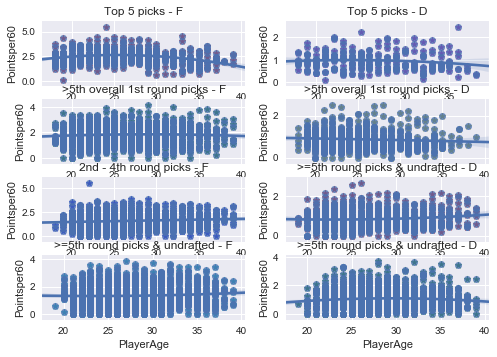

In [42]:
plt.subplot(421)
plt.scatter(f_arc_top5["PlayerAge"], f_arc_top5["Pointsper60"], marker='*', linestyle='-', color='r')
ax1 = sns.regplot(f_arc_top5["PlayerAge"], f_arc_top5["Pointsper60"], data=f_arc_top5, order=2)
plt.title('Top 5 picks - F')
plt.subplot(423)
plt.scatter(f_arc_other_first_round["PlayerAge"], f_arc_other_first_round["Pointsper60"], marker='*', linestyle='-', color='g')
ax2 = sns.regplot(f_arc_other_first_round["PlayerAge"], f_arc_other_first_round["Pointsper60"], data=f_arc_other_first_round, order=2)
plt.title('>5th overall 1st round picks - F')
plt.subplot(425)
plt.scatter(f_arc_2nd_4th_round["PlayerAge"], f_arc_2nd_4th_round["Pointsper60"], marker='*', linestyle='-', color='b')
ax3 = sns.regplot(f_arc_2nd_4th_round["PlayerAge"], f_arc_2nd_4th_round["Pointsper60"], data=f_arc_2nd_4th_round, order=2)
plt.title('2nd - 4th round picks - F')
plt.subplot(427)
plt.scatter(f_arc_5th_and_beyond["PlayerAge"], f_arc_5th_and_beyond["Pointsper60"], marker='*', linestyle='-', color='c')
ax4 = sns.regplot(f_arc_5th_and_beyond["PlayerAge"], f_arc_5th_and_beyond["Pointsper60"], data=f_arc_5th_and_beyond, order=2)
plt.title('>=5th round picks & undrafted - F')
plt.subplot(422)
plt.scatter(d_arc_top5["PlayerAge"], d_arc_top5["Pointsper60"], marker='*', linestyle='-', color='m')
ax5 = sns.regplot(d_arc_top5["PlayerAge"], d_arc_top5["Pointsper60"], data=d_arc_top5, order=2)
plt.title('Top 5 picks - D')
plt.subplot(424)
plt.scatter(d_arc_other_first_round["PlayerAge"], d_arc_other_first_round["Pointsper60"], marker='*', linestyle='-', color='y')
ax6 = sns.regplot(d_arc_other_first_round["PlayerAge"], d_arc_other_first_round["Pointsper60"], data=d_arc_other_first_round, order=2)
plt.title('>5th overall 1st round picks - D')
plt.subplot(426)
plt.scatter(d_arc_2nd_4th_round["PlayerAge"], d_arc_2nd_4th_round["Pointsper60"], marker='*', linestyle='-', color='r')
ax7 = sns.regplot(d_arc_2nd_4th_round["PlayerAge"], d_arc_2nd_4th_round["Pointsper60"], data=d_arc_2nd_4th_round, order=2)
plt.title('>=5th round picks & undrafted - D')
plt.subplot(428)
plt.scatter(d_arc_5th_and_beyond["PlayerAge"], d_arc_5th_and_beyond["Pointsper60"], marker='*', linestyle='-', color='g')
ax8 = sns.regplot(d_arc_5th_and_beyond["PlayerAge"], d_arc_5th_and_beyond["Pointsper60"], data=d_arc_5th_and_beyond, order=2)
plt.title('>=5th round picks & undrafted - D')
plt.show()


These charts look pretty promsing but hard to compare to each other, mostly because I suck at matplotlib. Let's re-plot it all on the same chart, and hide all the individiaul data points.

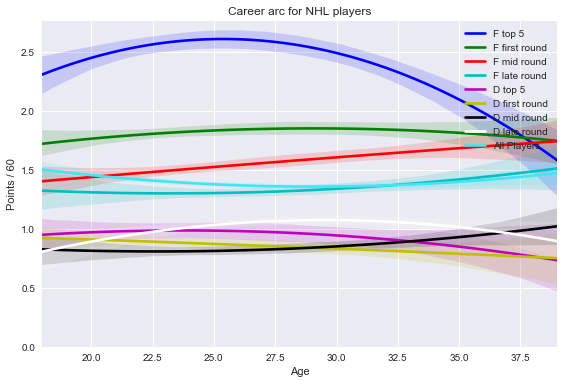

In [43]:
f, ax = plt.subplots()
ax.set(xlim=(min(career_arc["PlayerAge"]), max(career_arc['PlayerAge'])), ylim=(min(career_arc["Pointsper60"]), max(career_arc["Pointsper60"])/2))
sns.regplot(f_arc_top5["PlayerAge"], f_arc_top5["Pointsper60"], data=f_arc_top5, order=2, scatter=False, label="F top 5", color = 'b')
sns.regplot(f_arc_other_first_round["PlayerAge"], f_arc_other_first_round["Pointsper60"], data=f_arc_other_first_round, order=2, scatter=False, label="F first round", color = 'g')
sns.regplot(f_arc_2nd_4th_round["PlayerAge"], f_arc_2nd_4th_round["Pointsper60"], data=f_arc_2nd_4th_round, order=2, scatter=False, label="F mid round", color = 'r')
sns.regplot(f_arc_5th_and_beyond["PlayerAge"], f_arc_5th_and_beyond["Pointsper60"], data=f_arc_5th_and_beyond, order=2, scatter=False, label="F late round", color='c')
sns.regplot(d_arc_top5["PlayerAge"], d_arc_top5["Pointsper60"], data=d_arc_top5, order=2, scatter=False, label="D top 5", color = 'm')
sns.regplot(d_arc_other_first_round["PlayerAge"], d_arc_other_first_round["Pointsper60"], data=d_arc_other_first_round, order=2, scatter=False, label="D first round", color = 'y')
sns.regplot(d_arc_2nd_4th_round["PlayerAge"], d_arc_2nd_4th_round["Pointsper60"], data=d_arc_2nd_4th_round, order=2, scatter=False, label="D mid round", color = 'k')
sns.regplot(d_arc_5th_and_beyond["PlayerAge"], d_arc_5th_and_beyond["Pointsper60"], data=d_arc_5th_and_beyond, order=2, scatter=False, label="D late round", color = 'w')
sns.regplot(career_arc["PlayerAge"], career_arc["Pointsper60"], data=career_arc, order=2, scatter=False, label="All Players", color = '#42e5f4')
plt.legend(loc='upper right')
plt.title('Career arc for NHL players')
plt.xlabel('Age')
plt.ylabel('Points / 60')
plt.tight_layout()
plt.show()

The colors could be better represented better, but this shows some pretty cool data. That's it for now.